<a href="https://colab.research.google.com/github/Chay16/dataflowr-PlutonAI/blob/master/01_practical_PlutonAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# More dogs and cats!

This time, you are going to use the [Oxford-IIIT Pet Dataset](http://www.robots.ox.ac.uk/~vgg/data/pets/) by [O. M. Parkhi et al., 2012](http://www.robots.ox.ac.uk/~vgg/publications/2012/parkhi12a/parkhi12a.pdf) which features 12 cat breeds and 25 dogs breeds. You will need to adapt the code from lesson 1 to this new task, i.e. a classification with 37 categories.

##  Imports

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
import torchvision
from torchvision import models,transforms,datasets
import time
%matplotlib inline

In [0]:
torch.__version__

'1.4.0'

In [0]:
import sys
sys.version

'3.6.9 (default, Nov  7 2019, 10:44:02) \n[GCC 8.3.0]'

Check if GPU is available and if not change the [runtime](https://jovianlin.io/pytorch-with-gpu-in-google-colab/).

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print('Using gpu: %s ' % torch.cuda.is_available())

Using gpu: True 


## Downloading the data

The data given on the website [Oxford-IIIT Pet Dataset](http://www.robots.ox.ac.uk/~vgg/data/pets/) is made of two files: `images.tar.gz` and `annotations.tar.gz`. We first need to download and decompress these files.

Depending if you use google colab or your own computer, you can adapt the code below to choose where to store the data.

To see where you are, you can use the standard unix comands:

In [0]:
%pwd

'/content'

If you want to change to a directory to store your data:

In [0]:
%cd #path

[Errno 2] No such file or directory: '#path'
/content


In [0]:
%pwd

'/content'

In [0]:
%mkdir data
# the line below needs to be adapted if not running on google colab 
%cd ./data/

/content/data


Now that you are in the right directory, you can download the data:

In [0]:
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz

--2020-04-08 11:54:45--  http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 791918971 (755M) [application/x-gzip]
Saving to: ‘images.tar.gz’

images.tar.gz       100%[===================>] 755.23M  11.9MB/s    in 66s     

2020-04-08 11:55:53 (11.4 MB/s) - ‘images.tar.gz’ saved [791918971/791918971]

--2020-04-08 11:55:54--  http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19173078 (18M) [application/x-gzip]
Saving to: ‘annotations.tar.gz’

annotations.tar.gz  100%[===================>]  18.28M  5.54MB/s    in 3.3s    

2020-04-08 11:55:58 (5.54 MB/s)

and uncompress it:

In [0]:
!tar zxvf images.tar.gz
!tar zxvf annotations.tar.gz

Check that everything went correctly!

In [0]:
%ls

annotations/  annotations.tar.gz  images/  images.tar.gz


## Warning

If you are running this notebook on your own computer, you need to download the data only once. If you want to run this notebook a second time, you can safely skip this section and the secion below as your dataset will be stored nicely on your computer.

If you are running this notebook on google colab, you need to download the data and to do the data wrangling each time you are running this notebook as data will be cleared once you log off.

## 1. Exercise: data wrangling

You will first need to do a bit of [data wrangling](https://en.wikipedia.org/wiki/Data_wrangling) to organize your dataset in order to use the PyTorch `dataloader`.

If you want to understand how the files are organized, have a look at the `README` file in the folder `annotations`.

First, we need to split the dataset in a test set and train/validation set. For this, we can use the files `annotations/test.txt` and `annotations/trainval.txt` containing the names of images contained in the test and train/validation sets of the original paper.

In [0]:
!head annotations/test.txt

Abyssinian_201 1 1 1
Abyssinian_202 1 1 1
Abyssinian_204 1 1 1
Abyssinian_205 1 1 1
Abyssinian_206 1 1 1
Abyssinian_207 1 1 1
Abyssinian_20 1 1 1
Abyssinian_210 1 1 1
Abyssinian_212 1 1 1
Abyssinian_213 1 1 1


In [0]:
!head annotations/trainval.txt

Abyssinian_100 1 1 1
Abyssinian_101 1 1 1
Abyssinian_102 1 1 1
Abyssinian_103 1 1 1
Abyssinian_104 1 1 1
Abyssinian_105 1 1 1
Abyssinian_106 1 1 1
Abyssinian_107 1 1 1
Abyssinian_108 1 1 1
Abyssinian_109 1 1 1


Above you see that the authors of the original paper made a partition of the dataset: `./images/Abyssinian_201.jpg` is in the test set while `./images/Abyssinian_100.jpg` is in the train/validation set and so on.

BTW, it you wonder what Abyssinian means, it is explain [here](https://en.wikipedia.org/wiki/Abyssinian_cat)

We first create two directories where we will put images form the test and trainval sets.

In [0]:
%mkdir test
%mkdir trainval

In [0]:
%ls

annotations/  annotations.tar.gz  images/  images.tar.gz  test/  trainval/




```
# Ce texte est au format code
```

Now it's your turn!

All the images are in the `./images/` folder and you want to store the data according to the following structure:
```bash
.
├── test
|   └── Abyssinian # contains images of Abyssinian from the test set
|   └── Bengal # contains images of Bengal from the test set
|    ... 
|   └── american_bulldog # contains images of american bulldog from the test set
|    ...
├── trainval
|   └── Abyssinian # contains images of Abyssinian from the trainval set
|   └── Bengal # contains images of Bengal from the trainval set
|    ...
|   └── american_bulldog # contains images of american bulldog from the trainval set
|    ...
```

Note that all images wiht a name starting with a majuscule is a cat and all images with a name starting with a minuscule is a dog.

So here is one way to achieve your task: you will read the `./annotations/test.txt` file line by line; from each line, you will extract the name of the corresponding file and then copy it from the `./images/filename_##.jpg` to `./test/filename/filename_##.jpg`, where `##` is a number.

Then you'll do the same thing for `trainval.txt` file.

Below is a little piece of code to show you how to open a file and read it line by line:

In [0]:
with open('./annotations/test.txt') as fp:
    line = fp.readline()
    while line:
        f,_,_,_ = line.split(' ')
        print(f)
        line = fp.readline()
        break

Abyssinian_201


In order to remove the `_201` in the example above, you can use the `re` [regular expression lib](https://docs.python.org/3.6/library/re.html) as follows:

In [0]:
import re
pat = re.compile(r'_\d')
res,_ = pat.split(f)
print(res)

Abyssinian


This small piece of code might be useful:

In [0]:
# create directory if it does not exist
def check_dir(dir_path):
    dir_path = dir_path.replace('//','/')
    os.makedirs(dir_path, exist_ok=True)

Some more hints:
- for moving files around you can use the `shutil` lib, see [here](https://docs.python.org/3.6/library/shutil.html#shutil.copy)
- you can use `os.path.join`
- have a look at python [f-string](https://cito.github.io/blog/f-strings/)

In [0]:
import shutil

In [0]:
# Here your code for test
with open('./annotations/test.txt') as fp:
    line = fp.readline()
    while line:
        f,_,_,_ = line.split(' ')
        foldername,_ = pat.split(f)
        check_dir(os.path.join("test",foldername))
        shutil.copyfile(os.path.join("images/","{}.jpg".format(f)),os.path.join("test/",foldername,"{}.jpg".format(f)))
        line = fp.readline()

In [0]:
# Here your code for train
with open('./annotations/trainval.txt') as fp:
    line = fp.readline()
    while line:
        f,_,_,_ = line.split(' ')
        foldername,_ = pat.split(f)
        check_dir(os.path.join("trainval",foldername))
        shutil.copyfile(os.path.join("images/","{}.jpg".format(f)),os.path.join("trainval/",foldername,"{}.jpg".format(f)))
        line = fp.readline()

## Data processing

In [0]:
%cd ..

/content


Now you are ready to redo what we did during lesson 1.

Below, you give the path where the data is stored. If you are running this code on your computer, you should modifiy this cell.

In [0]:
data_dir = '/content/data/'

```datasets``` is a class of the ```torchvision``` package (see [torchvision.datasets](http://pytorch.org/docs/master/torchvision/datasets.html)) and deals with data loading. It integrates a multi-threaded loader that fetches images from the disk, groups them in mini-batches and serves them continously to the GPU right after each _forward_/_backward_ pass through the network.

Images needs a bit of preparation before passing them throught the network. They need to have all the same size $224\times 224 \times 3$ plus some extra formatting done below by the normalize transform (explained later).

In [0]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

vgg_format = transforms.Compose([
                transforms.CenterCrop(224),
                transforms.ToTensor(),
                normalize,
            ])

In [0]:
dsets = {x: datasets.ImageFolder(os.path.join(data_dir, x), vgg_format)
         for x in ['trainval', 'test']}

In [0]:
os.path.join(data_dir,'trainval')

'/content/data/trainval'

We now have 37 different classes.

In [0]:
dsets['trainval'].classes

['Abyssinian',
 'Bengal',
 'Birman',
 'Bombay',
 'British_Shorthair',
 'Egyptian_Mau',
 'Maine_Coon',
 'Persian',
 'Ragdoll',
 'Russian_Blue',
 'Siamese',
 'Sphynx',
 'american_bulldog',
 'american_pit_bull_terrier',
 'basset_hound',
 'beagle',
 'boxer',
 'chihuahua',
 'english_cocker_spaniel',
 'english_setter',
 'german_shorthaired',
 'great_pyrenees',
 'havanese',
 'japanese_chin',
 'keeshond',
 'leonberger',
 'miniature_pinscher',
 'newfoundland',
 'pomeranian',
 'pug',
 'saint_bernard',
 'samoyed',
 'scottish_terrier',
 'shiba_inu',
 'staffordshire_bull_terrier',
 'wheaten_terrier',
 'yorkshire_terrier']

In [0]:
dsets['trainval'].class_to_idx

{'Abyssinian': 0,
 'Bengal': 1,
 'Birman': 2,
 'Bombay': 3,
 'British_Shorthair': 4,
 'Egyptian_Mau': 5,
 'Maine_Coon': 6,
 'Persian': 7,
 'Ragdoll': 8,
 'Russian_Blue': 9,
 'Siamese': 10,
 'Sphynx': 11,
 'american_bulldog': 12,
 'american_pit_bull_terrier': 13,
 'basset_hound': 14,
 'beagle': 15,
 'boxer': 16,
 'chihuahua': 17,
 'english_cocker_spaniel': 18,
 'english_setter': 19,
 'german_shorthaired': 20,
 'great_pyrenees': 21,
 'havanese': 22,
 'japanese_chin': 23,
 'keeshond': 24,
 'leonberger': 25,
 'miniature_pinscher': 26,
 'newfoundland': 27,
 'pomeranian': 28,
 'pug': 29,
 'saint_bernard': 30,
 'samoyed': 31,
 'scottish_terrier': 32,
 'shiba_inu': 33,
 'staffordshire_bull_terrier': 34,
 'wheaten_terrier': 35,
 'yorkshire_terrier': 36}

In [0]:
dset_sizes = {x: len(dsets[x]) for x in ['trainval', 'test']}
dset_sizes

{'test': 3669, 'trainval': 3680}

In [0]:
dset_classes = dsets['trainval'].classes

The ```torchvision``` packages allows complex pre-processing/transforms of the input data (_e.g._ normalization, cropping, flipping, jittering). A sequence of transforms can be grouped in a pipeline with the help of the ```torchvision.transforms.Compose``` function, see [torchvision.transforms](http://pytorch.org/docs/master/torchvision/transforms.html)

In [0]:
loader_train = torch.utils.data.DataLoader(dsets['trainval'], batch_size=64, shuffle=True, num_workers=6) #your code here

In [0]:
loader_valid = torch.utils.data.DataLoader(dsets['test'], batch_size=5, shuffle=False, num_workers=6)#your code here

Check your dataloader and everything is doing fine

In [0]:
count = 1
for data in loader_valid:
    print(count, end=',')
    if count == 1:
        inputs_try,labels_try = data
    count += 1

1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,

In [0]:
labels_try

tensor([0, 0, 0, 0, 0])

In [0]:
inputs_try.shape

torch.Size([5, 3, 224, 224])

A small function to display images:

In [0]:
def imshow(inp, title=None):
#   Imshow for Tensor.
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = np.clip(std * inp + mean, 0,1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

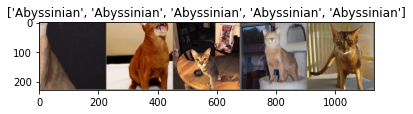

In [0]:
# Make a grid from batch
out = torchvision.utils.make_grid(inputs_try)

imshow(out, title=[dset_classes[x] for x in labels_try])

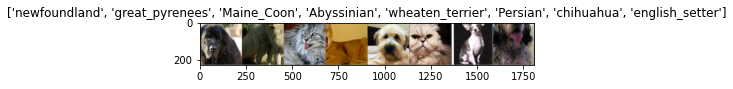

In [0]:
# Get a batch of training data
inputs, classes = next(iter(loader_train))

n_images = 8

# Make a grid from batch
out = torchvision.utils.make_grid(inputs[0:n_images])

imshow(out, title=[dset_classes[x] for x in classes[0:n_images]])

## 2. Exercise: modifying VGG Model

The torchvision module comes with a zoo of popular CNN architectures which are already trained on [ImageNet](http://www.image-net.org/) (1.2M training images). When called the first time, if ```pretrained=True``` the model is fetched over the internet and downloaded to ```~/.torch/models```.
For next calls, the model will be directly read from there.

In [0]:
model_vgg = models.vgg16(pretrained=True) #your code here

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth


In [0]:
inputs_try , labels_try = inputs_try.to(device), labels_try.to(device)

model_vgg = model_vgg.to(device)

In [0]:
outputs_try = model_vgg(inputs_try)

In [0]:
outputs_try

tensor([[-2.2195, -2.5892, -1.4617,  ...,  0.0746, -2.2245,  3.6829],
        [-3.9346,  1.1617, -3.4430,  ..., -2.4231,  2.7654,  4.3374],
        [-0.1112,  1.0341, -0.7879,  ..., -1.5549,  1.2486,  1.8674],
        [ 0.7685, -0.1766,  0.3167,  ..., -2.5920,  0.6288,  1.6975],
        [-1.8933, -0.7308, -3.7448,  ..., -7.1715,  5.0777,  2.6347]],
       device='cuda:0', grad_fn=<AddmmBackward>)

In [0]:
outputs_try.shape

torch.Size([5, 1000])

### Modifying the last layer and setting the gradient false to all layers

In [0]:
print(model_vgg)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

We'll learn about what these different blocks do later in the course. For now, it's enough to know that:

- Convolution layers are for finding small to medium size patterns in images -- analyzing the images locally
- Dense (fully connected) layers are for combining patterns across an image -- analyzing the images globally
- Pooling layers downsample -- in order to reduce image size and to improve invariance of learned features

![vgg16](https://mlelarge.github.io/dataflowr/Notebooks/vgg16.png)

Here, our goal is to use the already trained model and just change the number of output classes. To this end we replace the last ```nn.Linear``` layer trained for 1000 classes to ones with 37 classes. In order to freeze the weights of the other layers during training, we set the field ```required_grad=False```. In this manner no gradient will be computed for them during backprop and hence no update in the weights. Only the weights for the 37 class layer will be updated.

PyTorch documentation for [LogSoftmax](https://pytorch.org/docs/stable/nn.html#logsoftmax)

In [0]:
for param in model_vgg.parameters():
    param.requires_grad = False
# your code here
model_vgg.classifier._modules['6'] = nn.Linear(4096,len(dset_classes))
model_vgg.classifier._modules['7'] = torch.nn.LogSoftmax(dim = 1)

In [0]:
print(model_vgg.classifier)

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=37, bias=True)
  (7): LogSoftmax()
)


Once you modified the architecture of the network, do not forget to put in onto the device!

In [0]:
# your code here
model_vgg.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

## Training fully connected module

### Creating loss function and optimizer

PyTorch documentation for [NLLLoss](https://pytorch.org/docs/stable/nn.html#nllloss) and the [torch.optim module](https://pytorch.org/docs/stable/optim.html#module-torch.optim)

In [0]:
criterion = nn.NLLLoss()
lr = 0.001
optimizer_vgg = torch.optim.SGD(model_vgg.classifier[6].parameters(),lr = lr)

### Training the model

In [0]:
def train_model(model,dataloader,size,epochs=1,optimizer=None):
    model.train()
    
    for epoch in range(epochs):
        running_loss = 0.0
        running_corrects = 0
        for inputs,classes in dataloader:
            inputs = inputs.to(device)
            classes = classes.to(device)
            outputs = model(inputs)
            loss = criterion(outputs,classes)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            _,preds = torch.max(outputs.data,1)
            # statistics
            running_loss += loss.data.item()
            running_corrects += torch.sum(preds == classes.data)
        epoch_loss = running_loss / size
        epoch_acc = running_corrects.data.item() / size
        print('Loss: {:.4f} Acc: {:.4f}'.format(
                     epoch_loss, epoch_acc))

In [0]:
%%time
train_model(model_vgg,loader_train,size=dset_sizes['trainval'],epochs=2,optimizer=optimizer_vgg)

Loss: 0.0518 Acc: 0.1495
Loss: 0.0387 Acc: 0.4356
CPU times: user 21.6 s, sys: 14.9 s, total: 36.5 s
Wall time: 1min 16s


In [0]:
def test_model(model,dataloader,size):
    model.eval()
    predictions = np.zeros(size)
    all_classes = np.zeros(size)
    all_proba = np.zeros((size,37))
    i = 0
    running_loss = 0.0
    running_corrects = 0
    #print(size)
    for inputs,classes in dataloader:
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model(inputs)
        loss = criterion(outputs,classes)           
        _,preds = torch.max(outputs.data,1)
            # statistics
        #print(inputs.shape,preds.shape,len(classes))
        #print(i,classes)
        running_loss += loss.data.item()
        running_corrects += torch.sum(preds == classes.data)
        predictions[i:i+len(classes)] = preds.to('cpu').numpy()
        all_classes[i:i+len(classes)] = classes.to('cpu').numpy()
        all_proba[i:i+len(classes),:] = outputs.data.to('cpu').numpy()
        i += len(classes)
    epoch_loss = running_loss / size
    epoch_acc = running_corrects.data.item() / size
    print('Loss: {:.4f} Acc: {:.4f}'.format(
                     epoch_loss, epoch_acc))
    return predictions, all_proba, all_classes

In [0]:
predictions, all_proba, all_classes = test_model(model_vgg,loader_valid,size=dset_sizes['test'])

Loss: 0.4083 Acc: 0.6991


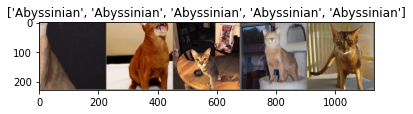

In [0]:
# Get a batch of training data
inputs, classes = next(iter(loader_valid))

out = torchvision.utils.make_grid(inputs[0:n_images])

imshow(out, title=[dset_classes[x] for x in classes[0:n_images]])

Compute the predictions made by your network for `inputs[:n_images]` and the associated probabilities.

Hint: use `torch.max` and `torch.exp`.

Do not forget to put your inputs on the device!

In [0]:
# your code here
output = model_vgg(inputs[:n_images].to(device))
probs_try, preds_try = torch.max(output, dim=1) # your code here

In [0]:
preds_try

tensor([34, 17, 17, 17, 17], device='cuda:0')

In [0]:
classes[:n_images]

tensor([0, 0, 0, 0, 0])

In [0]:
torch.exp(probs_try)

tensor([0.0450, 0.0881, 0.0543, 0.0677, 0.0877], device='cuda:0',
       grad_fn=<ExpBackward>)

## Speeding up the learning by precomputing features

In [0]:
def preconvfeat(dataloader):
    conv_features = []
    labels_list = []
    for data in dataloader:
        inputs,labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        x = model_vgg.features(inputs)
        conv_features.extend(x.data.cpu().numpy())
        labels_list.extend(labels.data.cpu().numpy())
    conv_features = np.concatenate([[feat] for feat in conv_features])
    return (conv_features,labels_list)

In [0]:
%%time
conv_feat_train,labels_train = preconvfeat(loader_train)

CPU times: user 11.5 s, sys: 8.52 s, total: 20 s
Wall time: 37.8 s


In [0]:
conv_feat_train.shape

(3680, 512, 7, 7)

In [0]:
%%time
conv_feat_valid,labels_valid = preconvfeat(loader_valid)

CPU times: user 54.2 s, sys: 36.1 s, total: 1min 30s
Wall time: 1min 31s


### Creating a new data generator

We will not load images anymore, so we need to build our own data loader.

In [0]:
dtype=torch.float
datasetfeat_train = [[torch.from_numpy(f).type(dtype),torch.tensor(l).type(torch.long)] for (f,l) in zip(conv_feat_train,labels_train)]
datasetfeat_train = [(inputs.reshape(-1), classes) for [inputs,classes] in datasetfeat_train]
loaderfeat_train = torch.utils.data.DataLoader(datasetfeat_train, batch_size=128, shuffle=True)

Now you can train for more epochs.

In [0]:
%%time
train_model(model_vgg.classifier,dataloader=loaderfeat_train,size=dset_sizes['trainval'],epochs=80,optimizer=optimizer_vgg)

Loss: 0.0158 Acc: 0.5883
Loss: 0.0142 Acc: 0.6454
Loss: 0.0129 Acc: 0.6842
Loss: 0.0118 Acc: 0.7171
Loss: 0.0109 Acc: 0.7394
Loss: 0.0102 Acc: 0.7565
Loss: 0.0095 Acc: 0.7693
Loss: 0.0091 Acc: 0.7731
Loss: 0.0086 Acc: 0.7932
Loss: 0.0081 Acc: 0.8063
Loss: 0.0079 Acc: 0.8014
Loss: 0.0076 Acc: 0.8052
Loss: 0.0072 Acc: 0.8209
Loss: 0.0070 Acc: 0.8285
Loss: 0.0068 Acc: 0.8264
Loss: 0.0066 Acc: 0.8348
Loss: 0.0063 Acc: 0.8340
Loss: 0.0062 Acc: 0.8440
Loss: 0.0061 Acc: 0.8351
Loss: 0.0059 Acc: 0.8451
Loss: 0.0059 Acc: 0.8416
Loss: 0.0057 Acc: 0.8465
Loss: 0.0055 Acc: 0.8562
Loss: 0.0055 Acc: 0.8543
Loss: 0.0053 Acc: 0.8614
Loss: 0.0052 Acc: 0.8568
Loss: 0.0051 Acc: 0.8568
Loss: 0.0051 Acc: 0.8579
Loss: 0.0051 Acc: 0.8625
Loss: 0.0049 Acc: 0.8630
Loss: 0.0048 Acc: 0.8666
Loss: 0.0048 Acc: 0.8636
Loss: 0.0047 Acc: 0.8677
Loss: 0.0046 Acc: 0.8747
Loss: 0.0046 Acc: 0.8682
Loss: 0.0045 Acc: 0.8720
Loss: 0.0045 Acc: 0.8658
Loss: 0.0044 Acc: 0.8758
Loss: 0.0044 Acc: 0.8712
Loss: 0.0043 Acc: 0.8764


In [0]:
datasetfeat_valid = [[torch.from_numpy(f).type(dtype),torch.tensor(l).type(torch.long)] for (f,l) in zip(conv_feat_valid,labels_valid)]
datasetfeat_valid = [(inputs.reshape(-1), classes) for [inputs,classes] in datasetfeat_valid]
loaderfeat_valid = torch.utils.data.DataLoader(datasetfeat_valid, batch_size=128, shuffle=False)

Now you can compute the accuracy on the test set.

In [0]:
predictions, all_proba, all_classes = test_model(model_vgg.classifier,dataloader=loaderfeat_valid,size=dset_sizes['test'])

Loss: 0.0035 Acc: 0.8820


## Confusion matrix

For 37 classes, plotting a confusion matrix is useful to see the performance of the algorithm per class.

In [0]:
#!pip install -U scikit-learn

In [0]:
from sklearn.metrics import confusion_matrix
import itertools
def make_fig_cm(cm):
    fig = plt.figure(figsize=(12,12))
    plt.imshow(cm, interpolation='nearest', cmap='Blues')
    tick_marks = np.arange(37);
    plt.xticks(tick_marks, dset_classes, rotation=90);
    plt.yticks(tick_marks, dset_classes, rotation=0);
    plt.tight_layout();
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        coeff = f'{cm[i, j]}'
        plt.text(j, i, coeff, horizontalalignment="center", verticalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('Actual');
    plt.xlabel('Predicted');

In [0]:
cm = confusion_matrix(all_classes,predictions)

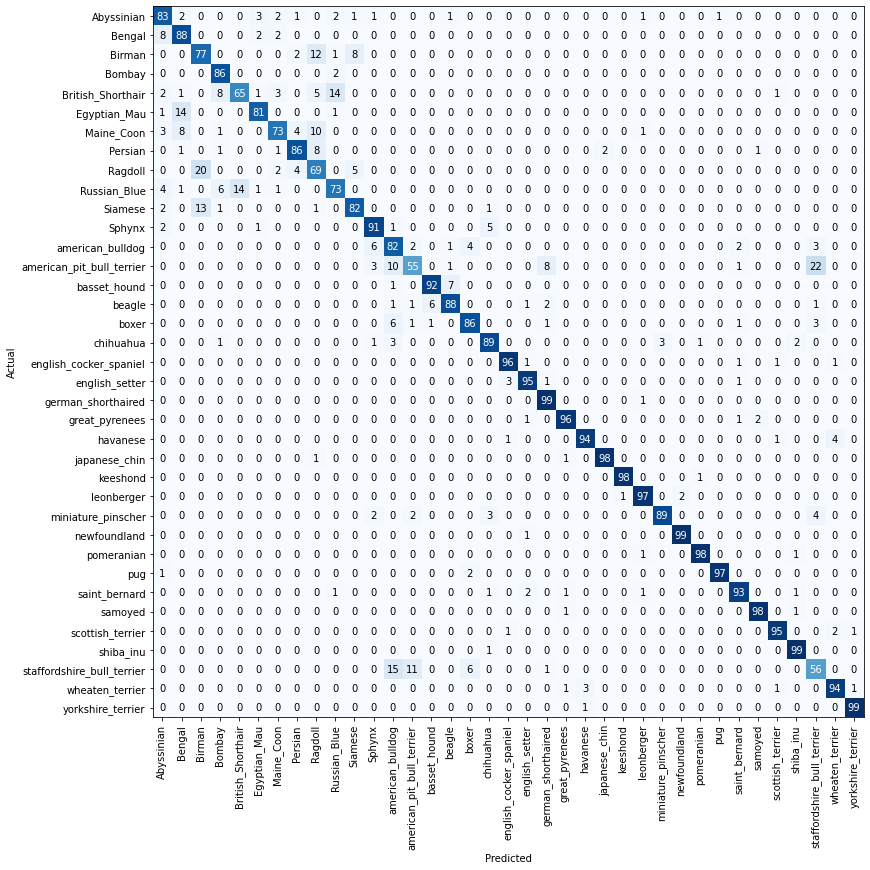

In [0]:
make_fig_cm(cm)

Here, you see that [american pit bull terrier](https://en.wikipedia.org/wiki/American_Pit_Bull_Terrier) are often predicted as [staffordshire bull terrier](https://en.wikipedia.org/wiki/Staffordshire_Bull_Terrier) but overall your algorithm should give pretty good results!

## 3. Exercise: change of neural network model

Great! So far, you reproduced the result of the first lesson. Now, you will need to take another model. I propose to take a `resnet34` from the list availabel [here](https://pytorch.org/docs/stable/torchvision/models.html)

__Note__ the main purpose of this exercise is to lean how to modify a network. We do not really care about performances...

In [0]:
model_resnet = models.resnet34(pretrained=True) # your code here

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


In [0]:
print(model_resnet)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

OK, the strucutre is quite different from the one of VGG we saw during the course but we stillwe see that the last layer is a Linear layer taking a vector of size 512 and producing a vector of size 1000 (i.e. the number of classes in Imagenet). Hence you should be able to modify this network for your classification task with 37 classes!

First freeze the weights of your model and replace the last layer by a Linear layer with the appropriate size.

In [0]:
# your code here
#Hint print(model_resnet.fc)
print(model_resnet.fc)
for param in model_resnet.parameters():
  param.requires_grad = False
model_resnet.fc = nn.Linear(512,len(dset_classes))
print(model_resnet.fc)

Linear(in_features=512, out_features=1000, bias=True)
Linear(in_features=512, out_features=37, bias=True)


Now we need to add the LogSoftmax layer. Follow the instructions [here](https://discuss.pytorch.org/t/how-to-add-an-additional-layer-on-top-of-a-pretrained-model/21303/2) to add this layer

In [0]:
model_resnet_lsm = nn.Sequential(model_resnet, 
                                 nn.LogSoftmax(dim=1)) # your code here

Check that everything is working fine!

In [0]:
inputs_try , labels_try = inputs_try.to(device), labels_try.to(device)
model_resnet_lsm = model_resnet_lsm.to(device)
outputs_try = model_resnet_lsm(inputs_try)

In [0]:
outputs_try.shape

torch.Size([5, 37])

Now you can start training.

You will take the same loss as before: [NLLLoss](https://pytorch.org/docs/stable/nn.html#nllloss) but you need to modify the argument of the optimizer [torch.optim module](https://pytorch.org/docs/stable/optim.html#module-torch.optim)

In [0]:
#Hint print(model_resnet_lsm[0].fc)
optimizer_resnet = torch.optim.SGD(model_resnet_lsm[0].fc.parameters(), lr=lr) #your code here

Now you can use the same function as above for the training loop.

In [0]:
%%time
train_model(model_resnet_lsm,loader_train,size=dset_sizes['trainval'],epochs=30,optimizer=optimizer_resnet)

Loss: 0.0582 Acc: 0.0402
Loss: 0.0549 Acc: 0.0745
Loss: 0.0523 Acc: 0.1383
Loss: 0.0500 Acc: 0.2027
Loss: 0.0478 Acc: 0.2747
Loss: 0.0457 Acc: 0.3533
Loss: 0.0437 Acc: 0.4204
Loss: 0.0417 Acc: 0.4842
Loss: 0.0400 Acc: 0.5321
Loss: 0.0383 Acc: 0.5655
Loss: 0.0366 Acc: 0.6168
Loss: 0.0353 Acc: 0.6440
Loss: 0.0338 Acc: 0.6690
Loss: 0.0324 Acc: 0.6897
Loss: 0.0311 Acc: 0.7087
Loss: 0.0301 Acc: 0.7245
Loss: 0.0289 Acc: 0.7375
Loss: 0.0279 Acc: 0.7549
Loss: 0.0269 Acc: 0.7614
Loss: 0.0259 Acc: 0.7764
Loss: 0.0252 Acc: 0.7793
Loss: 0.0244 Acc: 0.7959
Loss: 0.0237 Acc: 0.8003
Loss: 0.0230 Acc: 0.8033
Loss: 0.0223 Acc: 0.8082
Loss: 0.0217 Acc: 0.8160
Loss: 0.0211 Acc: 0.8204
Loss: 0.0205 Acc: 0.8231
Loss: 0.0200 Acc: 0.8280
Loss: 0.0195 Acc: 0.8348
CPU times: user 1min 43s, sys: 48.7 s, total: 2min 31s
Wall time: 9min 58s


In [0]:
%%time
predictions, all_proba, all_classes = test_model(model_resnet_lsm,loader_valid,size=dset_sizes['test'])

Loss: 0.2519 Acc: 0.7991
CPU times: user 18.3 s, sys: 7.29 s, total: 25.6 s
Wall time: 31.4 s


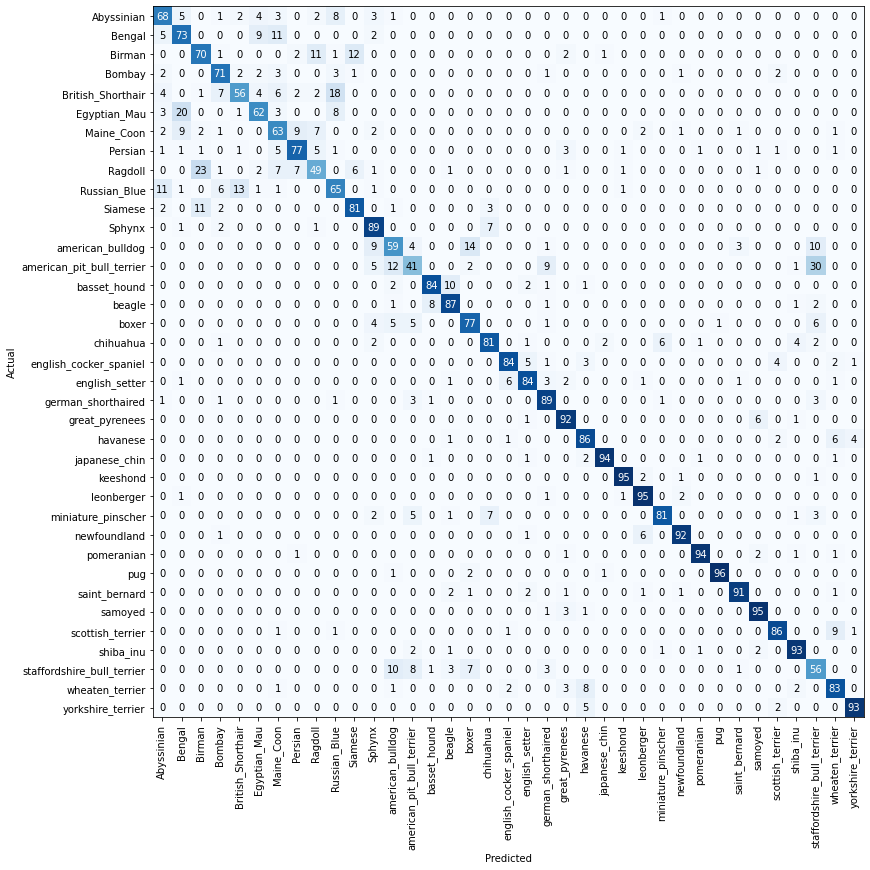

In [0]:
cm = confusion_matrix(all_classes,predictions)
make_fig_cm(cm)

## Well done!

What would you do to speed up the process in the last part?

In [0]:
def preconvfeat(dataloader):
    conv_features = []
    labels_list = []
    for data in dataloader:
        inputs,labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        x = model_resnet.conv1(inputs)
        x = model_resnet.bn1(x)
        x = model_resnet.relu(x)
        x = model_resnet.maxpool(x)
        x = model_resnet.layer1(x)
        x = model_resnet.layer2(x)
        x = model_resnet.layer3(x)
        x = model_resnet.layer4(x)
        x = model_resnet.avgpool(x)
        
        conv_features.extend(x.data.cpu().numpy())
        labels_list.extend(labels.data.cpu().numpy())
    conv_features = np.concatenate([[feat] for feat in conv_features])
    return (conv_features,labels_list)

In [0]:
%%time
conv_feat_train,labels_train = preconvfeat(loader_train)

CPU times: user 3.09 s, sys: 1.52 s, total: 4.61 s
Wall time: 19.8 s


In [0]:
conv_feat_train.shape

(3680, 512, 1, 1)

In [0]:
%%time
conv_feat_valid,labels_valid = preconvfeat(loader_valid)

CPU times: user 18.3 s, sys: 7.27 s, total: 25.5 s
Wall time: 31.3 s


In [0]:
dtype=torch.float
datasetfeat_train = [[torch.from_numpy(f).type(dtype),torch.tensor(l).type(torch.long)] for (f,l) in zip(conv_feat_train,labels_train)]
datasetfeat_train = [(inputs.reshape(-1), classes) for [inputs,classes] in datasetfeat_train]
loaderfeat_train = torch.utils.data.DataLoader(datasetfeat_train, batch_size=128, shuffle=True)

In [0]:
model_classifier = nn.Sequential(nn.Linear(512,len(dset_classes)),
                                 nn.LogSoftmax(dim=1))
model_classifier.to(device)

Sequential(
  (0): Linear(in_features=512, out_features=37, bias=True)
  (1): LogSoftmax()
)

In [0]:
%%time
optimizer_classifier = torch.optim.SGD(model_classifier.parameters(), lr=lr)
train_model(model_classifier,dataloader=loaderfeat_train,size=dset_sizes['trainval'],epochs=100,optimizer=optimizer_classifier)

Loss: 0.0298 Acc: 0.0266
Loss: 0.0289 Acc: 0.0416
Loss: 0.0281 Acc: 0.0598
Loss: 0.0274 Acc: 0.0815
Loss: 0.0267 Acc: 0.1117
Loss: 0.0261 Acc: 0.1446
Loss: 0.0254 Acc: 0.1804
Loss: 0.0249 Acc: 0.2212
Loss: 0.0243 Acc: 0.2625
Loss: 0.0237 Acc: 0.3005
Loss: 0.0231 Acc: 0.3378
Loss: 0.0226 Acc: 0.3745
Loss: 0.0221 Acc: 0.4144
Loss: 0.0215 Acc: 0.4448
Loss: 0.0211 Acc: 0.4769
Loss: 0.0206 Acc: 0.5095
Loss: 0.0201 Acc: 0.5359
Loss: 0.0196 Acc: 0.5630
Loss: 0.0192 Acc: 0.5823
Loss: 0.0187 Acc: 0.6016
Loss: 0.0183 Acc: 0.6220
Loss: 0.0179 Acc: 0.6427
Loss: 0.0175 Acc: 0.6565
Loss: 0.0171 Acc: 0.6674
Loss: 0.0167 Acc: 0.6802
Loss: 0.0164 Acc: 0.6937
Loss: 0.0161 Acc: 0.7068
Loss: 0.0157 Acc: 0.7160
Loss: 0.0154 Acc: 0.7258
Loss: 0.0151 Acc: 0.7353
Loss: 0.0148 Acc: 0.7416
Loss: 0.0145 Acc: 0.7489
Loss: 0.0142 Acc: 0.7535
Loss: 0.0139 Acc: 0.7609
Loss: 0.0137 Acc: 0.7668
Loss: 0.0134 Acc: 0.7726
Loss: 0.0132 Acc: 0.7780
Loss: 0.0129 Acc: 0.7821
Loss: 0.0127 Acc: 0.7840
Loss: 0.0125 Acc: 0.7932


In [0]:
datasetfeat_valid = [[torch.from_numpy(f).type(dtype),torch.tensor(l).type(torch.long)] for (f,l) in zip(conv_feat_valid,labels_valid)]
datasetfeat_valid = [(inputs.reshape(-1), classes) for [inputs,classes] in datasetfeat_valid]
loaderfeat_valid = torch.utils.data.DataLoader(datasetfeat_valid, batch_size=128, shuffle=False)

In [0]:
predictions, all_proba, all_classes = test_model(model_classifier,dataloader=loaderfeat_valid,size=dset_sizes['test'])

Loss: 0.0072 Acc: 0.8376


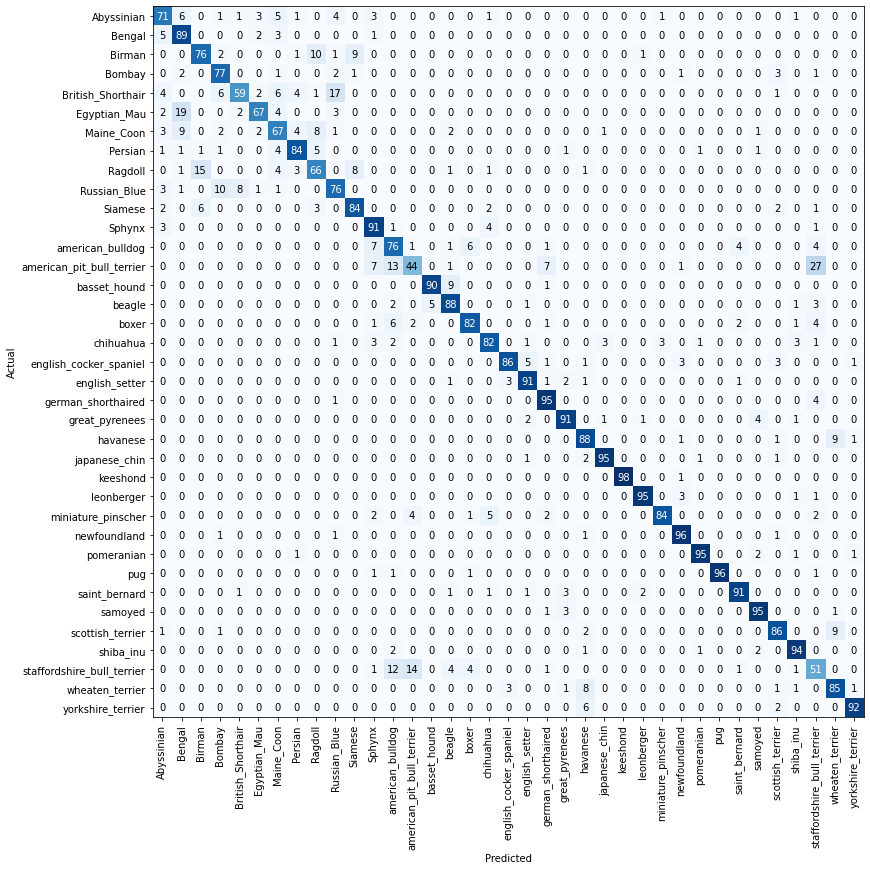

In [0]:
cm = confusion_matrix(all_classes,predictions)
make_fig_cm(cm)